In [1]:
!pip install tensorflow==2.10.0
!pip install numpy==1.23


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf
print(tf.__version__)  # Should output: 2.10.0

c:\Python310\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


2.10.0


In [14]:
pip show tensorflow


Name: tensorflow
Version: 2.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\python310\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

print(f"TRAIN_DIR VALID: ", len(os.listdir(os.path.join("/content/drive/MyDrive/", "sinusities/dataset/train/valid"))))
print(f"TRAIN_DIR INVALID: ", len(os.listdir(os.path.join("/content/drive/MyDrive/", "sinusities/dataset/train/invalid"))))

print(f"VAL_DIR VALID: ", len(os.listdir(os.path.join("/content/drive/MyDrive/", "sinusities/dataset/validate/valid"))))
print(f"VAL_DIR INVALID: ", len(os.listdir(os.path.join("/content/drive/MyDrive/", "sinusities/dataset/validate/invalid"))))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TRAIN_DIR VALID:  1833
TRAIN_DIR INVALID:  37
VAL_DIR VALID:  45
VAL_DIR INVALID:  17


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs found: {gpus}")

    # Optional: Set memory growth to avoid memory errors
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs found. Training will use CPU.")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Mount Google Drive (if using Google Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# Constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 25

# Directories
# TRAIN_DIR = "/content/drive/MyDrive/sinusities/dataset/train"
# VAL_DIR = "/content/drive/MyDrive/sinusities/dataset/validate"
TRAIN_DIR = r"G:\My Drive\sinusities\dataset\train"
VAL_DIR = r"G:\My Drive\sinusities\dataset\validate"

# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create train and validation datasets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
    # subset='training'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
    # subset='validation'
)

# Compute class weights to handle imbalance
classes = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# Load MobileNetV2 as a feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze the base model

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Change file extension to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)





Found 3943 images belonging to 2 classes.
Found 396 images belonging to 2 classes.
Class Weights: {0: 0.98575, 1: 1.0146680391147709}
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128 

## Save the trained model

In [18]:

# Save the trained model
model.save(r"G:\My Drive\sinusities\waters_view_validator_pc_new.h5")
           
print(f"Model Saved")

Model Saved


## Plot training & validation

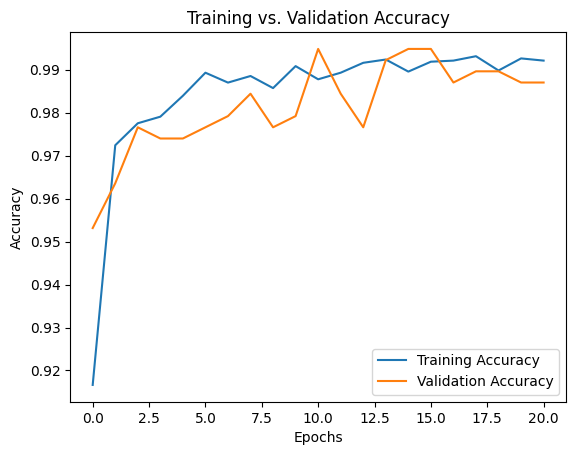

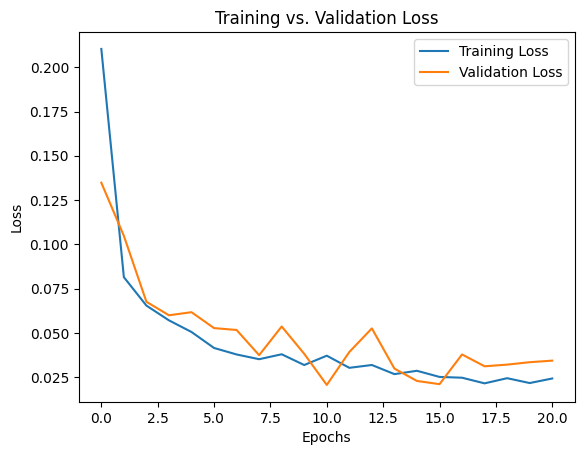

In [19]:

import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

## Evaluate the model on validation data

In [20]:
print(f"Total number of layers: {len(model.layers)}")

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

Total number of layers: 157
13/13 [==============================] - 7s 516ms/step - loss: 0.0270 - accuracy: 0.9924
Validation Loss: 0.0270
Validation Accuracy: 0.9924
124/124 [==============================] - 96s 774ms/step - loss: 0.0212 - accuracy: 0.9939
Training Loss: 0.0212
Training Accuracy: 0.9939


## Confusion Matrix

['invalid\\1-2-826-0-1-3680043-8-498-10121269997000927609159070327294073193-c_png_jpg.rf.ab7759b901ae421eb131a332cec6069d.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-10427172117186975182820246291573629157-c_png_jpg.rf.551a2edf3714fa933d8ac690d9fb6a61.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-10612106963266451108545196129578586927-c_png_jpg.rf.7e45f39adbe4bd08d8b97058d9fbb242.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-10888192607734246062570568056428363685-c_png_jpg.rf.dd57a42706feff0726edc76652c26c69.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-11062758981428680802704515078902697545-c_png_jpg.rf.0100fc60394fb19e530ac8ba5a631310.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-11381445165642905797838985324653739773-c_png_jpg.rf.4facb88cf8fccc30173900bab6956c2f.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-11519799070129574273212741230310415757-c_png_jpg.rf.d434142945073cb6eeddab975e279c08.jpg', 'invalid\\1-2-826-0-1-3680043-8-498-11558866520660138931650976459278451094-c_png_jpg.rf.88be45f84866e1c722ff33

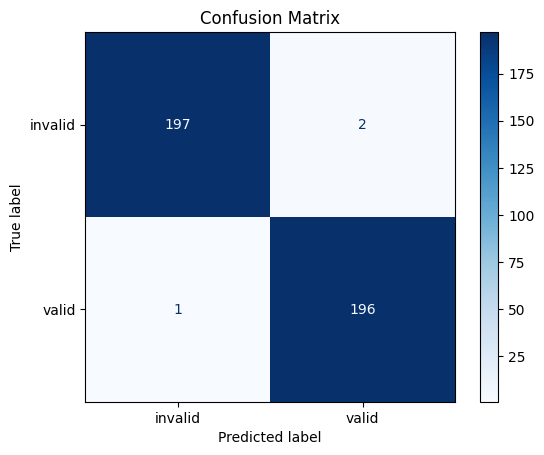

In [21]:

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print(val_generator.filenames[:10])

# Get predictions from the model
# val_generator.reset()  # Reset the generator to ensure proper alignment
predictions = model.predict(val_generator, verbose=1)

# Get true labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Convert probabilities to binary predictions for classification report
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
print("\nClassification Report:")
print(report)

# Verify alignment of classification accuracy with evaluate accuracy
classification_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Classification Accuracy: {classification_accuracy:.4f}")

#  Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
 

124/124 [==============================] - 98s 788ms/step

Classification Report:
              precision    recall  f1-score   support

     invalid     0.5059    0.5110    0.5085      2000
       valid     0.4914    0.4864    0.4889      1943

    accuracy                         0.4989      3943
   macro avg     0.4987    0.4987    0.4987      3943
weighted avg     0.4988    0.4989    0.4988      3943

Classification Accuracy: 0.4989


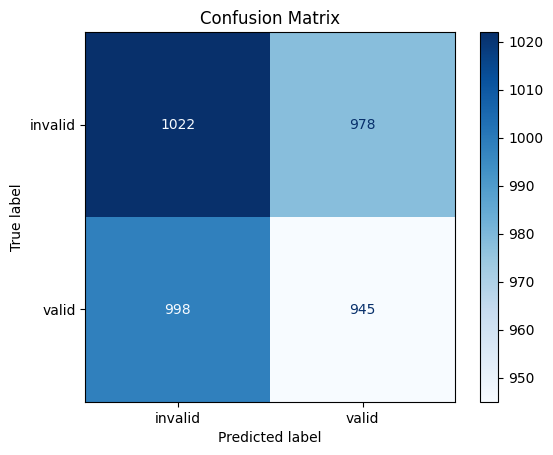

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
# train_generator.reset()  # Reset the generator
predictions = model.predict(train_generator, verbose=1)

# Get true labels
true_classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Convert probabilities to binary predictions for classification report
predicted_classes = np.argmax(predictions, axis=1) if predictions.shape[1] > 1 else (predictions > 0.5).astype(int).flatten()

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
print("\nClassification Report:")
print(report)

# Verify alignment of classification accuracy with evaluate accuracy
classification_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Classification Accuracy: {classification_accuracy:.4f}")

#  Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()